### Imports

In [1]:
from threading import Thread
import re
import autocorrect
from textstat.textstat import textstat
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import seaborn as sns
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samcoffey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/samcoffey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Config

In [2]:
#--------------------------------------------------------------------------------
# Set DATA_LOCAL to True if data is stored locally in '/data', otherwise set False
# and file will be downloaded from S3
#
# NOTE: Importing data from URL will take ~15-20s
#
#
DATA_LOCAL = True
LOCAL_PATH = "../data/"
REMOTE_PATH = "https://s3.amazonaws.com/coetichr/AmazonFoodReviews/"
DROP_COLS = ["ProductId", "UserId", "ProfileName", "Time", "Summary", "HelpfulnessDenominator", "HelpfulnessNumerator"]

# Plotting the token distributions takes a while, set PLOT_TOKEN_DIST to False to skip over them
PLOT_TOKEN_DIST = False

def load_data(file, nrows = -1):
    path = LOCAL_PATH if DATA_LOCAL else REMOTE_PATH
    if (nrows > -1):
        return pd.read_csv(path + file, nrows = nrows)
    else:
        return pd.read_csv(path + file)
#
#
#--------------------------------------------------------------------------------

### Load Data

In [3]:
# Load Reviews.csv
review_data = load_data("Reviews.csv", 50000)

# Print the first 5 lines
print("Number of rows: " + str(review_data.shape[0]))
review_data.head()

Number of rows: 50000


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Helper Methods

In [4]:
STOPWORDS = stopwords.words('english')
EXTRA_RM_WORDS = ['br', 'amazon', 'coffee']
STOPWORDS = STOPWORDS + EXTRA_RM_WORDS

#----- Sentence Property Computations ----------------------------------------

def word_count(sentence):
    return len(str(sentence).split(" "))

def avg_word_length(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words) / len(words))

def reduce_lengthening(text):
    # Corrects spelling errors where words have letters that have been
    # repeated 3+ times
    #
    # i.e. "amazzzing" => "amazzing"
    #
    # This serves as a preprocessor to the spell check so that
    # words will be correctly mapped to their correct counterparts
    # rather than being unrecognized
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

def count_stopwords(sentence):
    return len([word for word in sentence.split() if word in STOPWORDS])

def count_uppercase(sentence):
    return len([word for word in sentence.split() if word.isupper()])

def helpfulness(row, numer_col, denom_col):
    if (row[numer_col] == 0):
        if (row[denom_col] == 0):
            return 'NEUTRAL'
        else:
            return 'UNHELPFUL'
    else:
        if (float(row[numer_col] / row[denom_col]) >= 0.5):
            return 'HELPFUL'
        else:
            return 'UNHELPFUL'
    
def positivity(row, score_col):
    if (row[score_col] < 3):
        return 'NEGATIVE'
    elif (row[score_col] > 3):
        return 'POSITIVE'
    else:
        return 'NEUTRAL'
    
def remove_stopwords(sentence):
    return " ".join([word for word in sentence.split() if word not in STOPWORDS])

def correct_spelling(sentence):
    words = sentence.split()
    return " ".join(list(map(lambda w: autocorrect.spell(reduce_lengthening(w)), words)))

#----- Data Frame Column Computations ----------------------------------------

def set_word_count(df, text_col, wc_col):
    new_df = df.copy()
    new_df[wc_col] = new_df[text_col].apply(lambda x: word_count(x))
    return new_df

def set_avg_word_length(df, text_col, wl_col):
    new_df = df.copy()
    new_df[wl_col] = new_df[text_col].apply(lambda x: avg_word_length(x))
    return new_df

def set_stopword_count(df, text_col, sw_col):
    new_df = df.copy()
    new_df[sw_col] = new_df[text_col].apply(lambda x: count_stopwords(x))
    return new_df

def set_helpfulness(df, numer_col, denom_col, h_col):
    new_df = df.copy()
    new_df[h_col] = new_df.apply(lambda r: helpfulness(r, numer_col, denom_col), axis = 1)
    return new_df

def set_positivity(df, score_col, pos_col):
    new_df = df.copy()
    new_df[pos_col] = new_df.apply(lambda r: positivity(r, score_col), axis = 1)
    return new_df

def set_uppercase_count(df, text_col, upc_col):
    new_df = df.copy()
    new_df[upc_col] = new_df[text_col].apply(lambda x: count_uppercase(x))
    return new_df

def add_col_no_sw(df, text_col, new_text_col):
    new_df = df.copy()
    new_df[new_text_col] = new_df[text_col].apply(lambda x: remove_stopwords(x))
    return new_df

def set_flesch_readability(df, text_col, fr_col):
    new_df = df.copy()
    new_df[fr_col] = new_df[text_col].apply(lambda x: textstat.flesch_reading_ease(x))
    return new_df

def set_flesch_grade(df, text_col, fg_col):
    new_df = df.copy()
    new_df[fg_col] = new_df[text_col].apply(lambda x: textstat.flesch_kincaid_grade(x))
    return new_df

def add_col_spell_checked(df, text_col, new_text_col):
    new_df = df.copy()
    new_df[new_text_col] = new_df[text_col].apply(lambda x: correct_spelling(x))
    return new_df

#----- Plotting Methods ------------------------------------------------------

def countplot(df, xcol, title = 'Distribution', figsize = (12,6)):
    plt.subplots(figsize = figsize)
    sns.countplot(x = xcol, data = df, palette = "GnBu_d").set_title(title)
    plt.show()
    
def generate_wordcloud(df, text_col, max_feats = 75):
    vect = TfidfVectorizer(max_features = max_feats, lowercase = True, stop_words = STOPWORDS, ngram_range = (1,3)).fit(df.loc[:, text_col])
    wordcloud = WordCloud(width = 600, height = 400, 
        background_color ='white', 
        stopwords = STOPWORDS, 
        min_font_size = 10).generate(' '.join(vect.get_feature_names()))
    plt.figure(figsize = (8, 4), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

#-----------------------------------------------------------------------------

### Add Extra Columns & Remove Unneeded Columns

In [5]:
# Add extra computed property columns

now = time()
df = review_data.copy()
df = set_word_count(df, 'Text', 'WC')
df = set_avg_word_length(df, 'Text', 'AWL')
df = set_stopword_count(df, 'Text', 'SWC')
df = set_helpfulness(df, 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Help')
df = set_positivity(df, 'Score', 'Positivity')
df = set_uppercase_count(df, 'Text', 'UPC')
df = add_col_no_sw(df, 'Text', 'Text_NoSW')
df = set_avg_word_length(df, 'Text_NoSW', 'AWL_NoSW')
df = set_word_count(df, 'Text_NoSW', 'WC_NoSW')
df = set_flesch_readability(df, 'Text', 'Readability')
df = set_flesch_grade(df, 'Text', 'FleschGrade')
process_time = time() - now

# Remove columns that don't provide any information for analysis
#df.drop(columns = DROP_COLS, inplace = True, axis = 1)

# What's it look like now?
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,AWL,SWC,Help,Positivity,UPC,Text_NoSW,AWL_NoSW,WC_NoSW,Readability,FleschGrade
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,...,4.479167,21,HELPFUL,POSITIVE,1,I bought several Vitality canned dog food prod...,5.740741,27,72.16,7.2
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,...,5.161290,12,NEUTRAL,NEGATIVE,0,Product arrived labeled Jumbo Salted Peanuts.....,6.789474,19,61.02,7.3
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,...,4.372340,42,HELPFUL,POSITIVE,2,"This confection around centuries. It light, pi...",5.596154,52,76.72,5.4
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,...,4.317073,15,HELPFUL,NEGATIVE,4,If looking secret ingredient Robitussin I beli...,5.076923,26,66.03,7.5
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,...,4.111111,12,NEUTRAL,POSITIVE,0,Great taffy great price. There wide assortment...,5.533333,15,89.95,2.4


In [6]:
print("Time to process {0} records: {1:.2f}s ({2:.5f}s/rec)".format(df.shape[0], process_time, float(process_time/df.shape[0])))

Time to process 50000 records: 138.60s (0.00277s/rec)


In [7]:
#---------------------------------------------------------------------------------------------------------
#
# Possible solution for processing dataset in parallel 
# (still takes a very long time)
#
#
# import concurrent.futures

# CHUNK_SIZE = 100
# text_list = list(df.loc[:, "Text"])

# # Create a pool of processes. By default, one is created for each CPU in your machine.
# now = time()
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     df["TextSpellCheck"] = executor.map(correct_spelling, text_list, chunksize = CHUNK_SIZE)
# process_time = time() - now
#
#---------------------------------------------------------------------------------------------------------

In [8]:
# print(f"Time to process records concurrently: {process_time}s")

### Save the Processed Dataset

In [9]:
df.to_csv('../data/reviews_scored.csv')

### Lowest Flesch-Kincaid Grade Review

In [10]:
df.loc[df['FleschGrade'].idxmin(), "Text"]

'I like the syrup.  What more can I say. I like it.. I like it. I like it. I like it.'

### Highest Flesch-Kincaid Grade Review

In [11]:
df.loc[df['FleschGrade'].idxmax(), "Text"]

"i have been using fouresent bulbs in my house for a long time and the reson for this is that the wattage of the bulbs doesn't brake me up in electrical cost but when i ordered the earthmate bulb i didn't know what full spetrum was untill i put one of these bulbs in and saw the light output that i have been looking for since i been buying fouresent bulbs and the light is a light blue and now i can see things better because it a lot brighter that the other one i have been using so i am staying with these bulbs for her on out,fouresent bulbs save you a lot of money per year when you calculate out from a incondesent 60w light bulb to a 13w or 15w fouresent bulb i can use 4 15w flouresent bulbs compared to 1 60w incandesent light bulb because 60w bulb is 1/2 amp of electricity on your electrical circuit and after you start using this type of electricity in a years time starts to add up into money and i don't have that type of money to pay someone salery in the power companys, so i stay wit

### Positive Wordcloud

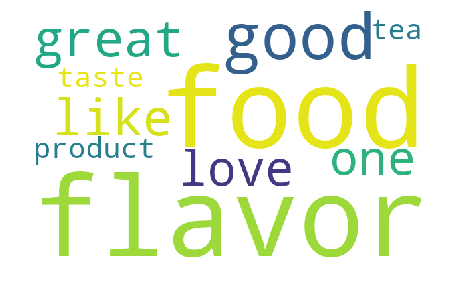

In [12]:
pos_df = df.copy()
pos_df = pos_df[pos_df['Positivity'] == 'POSITIVE']
generate_wordcloud(pos_df, 'Text_NoSW', 10)

### Negative Wordcloud

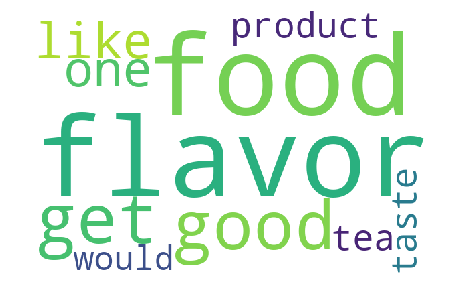

In [13]:
neg_df = df.copy()
neg_df = neg_df[neg_df['Positivity'] == 'NEGATIVE']
generate_wordcloud(neg_df, 'Text_NoSW', 10)

### Neutral Wordcloud

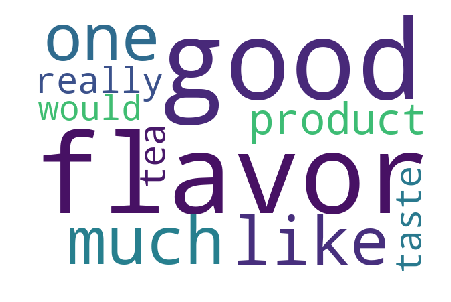

In [14]:
neut_df = df.copy()
neut_df = neut_df[neut_df['Positivity'] == 'NEUTRAL']
generate_wordcloud(neut_df, 'Text_NoSW', 10)

### Positivity Distribution

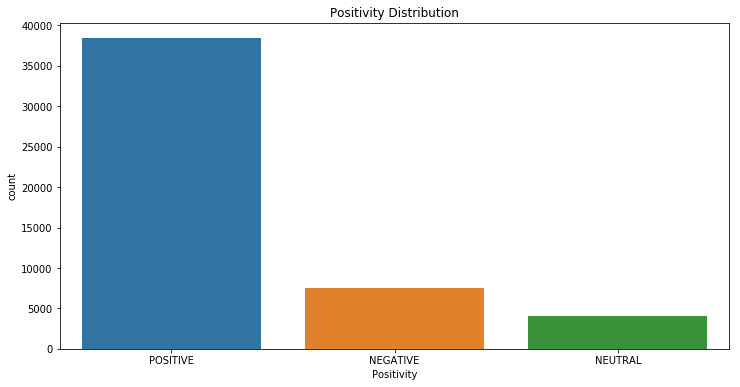

In [15]:
plt.subplots(figsize = (12, 6))
sns.countplot(x = "Positivity", data = df).set_title("Positivity Distribution")
plt.show()

### Helpfulness Distribution

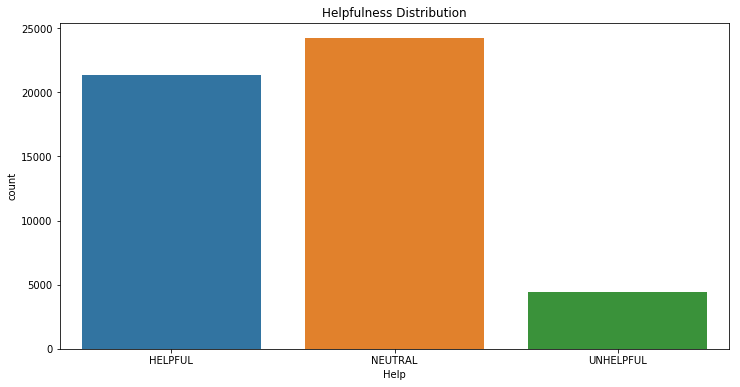

In [16]:
plt.subplots(figsize = (12, 6))
sns.countplot(x = "Help", data = df).set_title("Helpfulness Distribution")
plt.show()

### Score Distribution

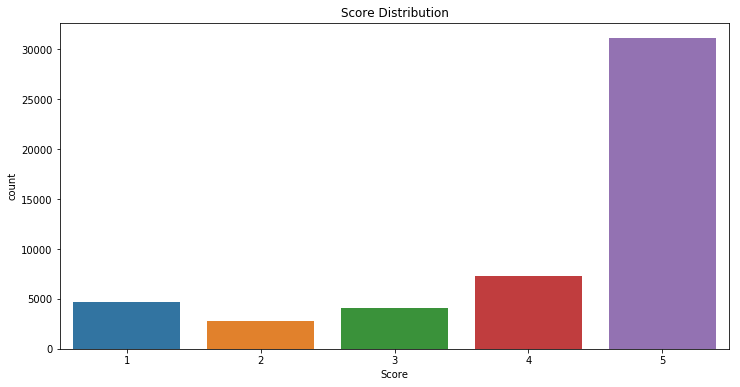

In [17]:
plt.subplots(figsize = (12, 6))
sns.countplot(x = "Score", data = df).set_title("Score Distribution")
plt.show()

### Mean Word Count by Score

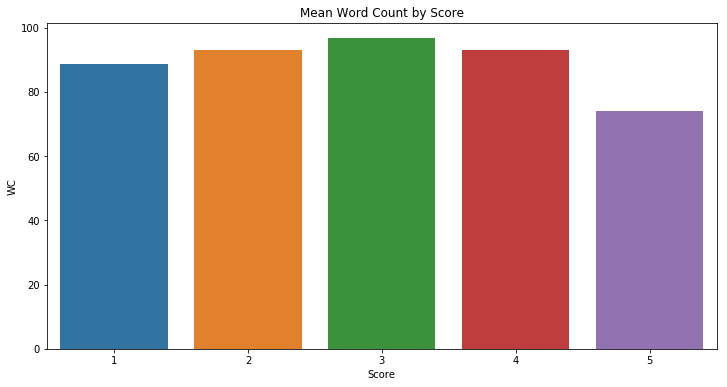

In [18]:
mean_wc_df = df.groupby('Score', as_index = False)['WC'].mean()
plt.subplots(figsize = (12, 6))
sns.barplot(x = "Score", y = "WC", data = mean_wc_df).set_title("Mean Word Count by Score")
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


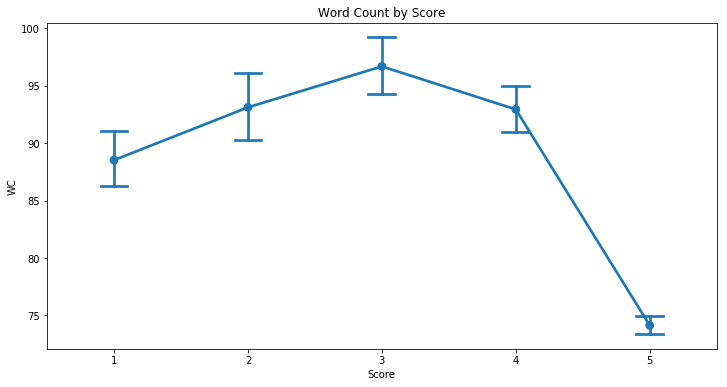

In [19]:
plt.subplots(figsize = (12, 6))
sns.pointplot(x="Score", y="WC", data=df, capsize=.2).set_title("Word Count by Score")
plt.show()

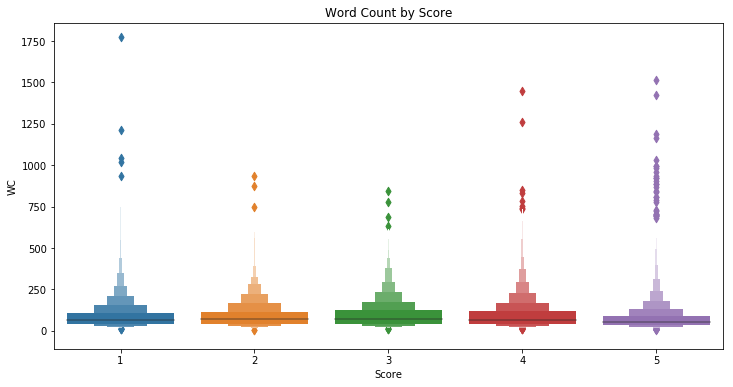

In [20]:
plt.subplots(figsize = (12, 6))
sns.boxenplot(x="Score", y="WC", data=df).set_title("Word Count by Score")
plt.show()

### Mean Uppercase Word Count by Score

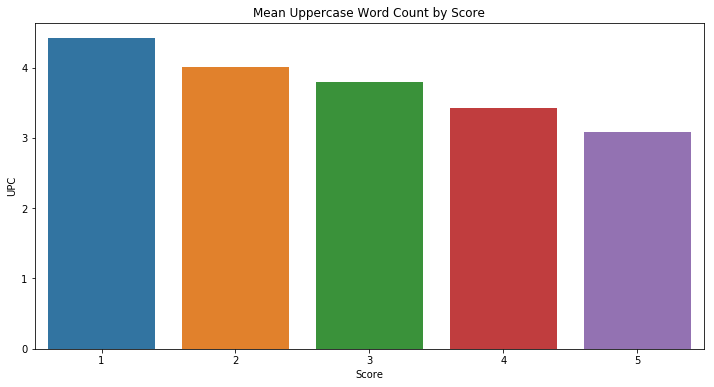

In [21]:
mean_wc_df = df.groupby('Score', as_index = False)['UPC'].mean()
plt.subplots(figsize = (12, 6))
sns.barplot(x = "Score", y = "UPC", data = mean_wc_df).set_title("Mean Uppercase Word Count by Score")
plt.show()

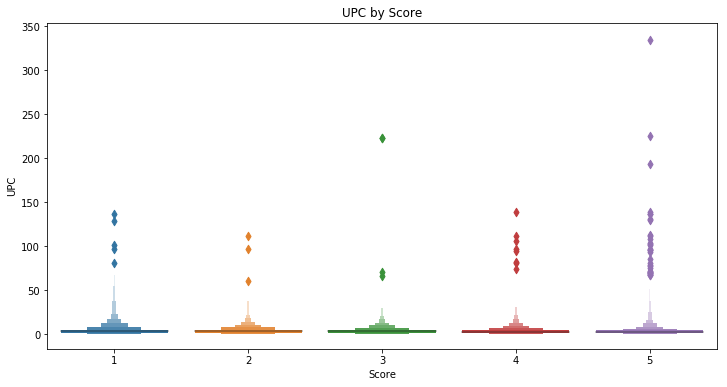

In [22]:
plt.subplots(figsize = (12, 6))
sns.boxenplot(x="Score", y="UPC", data=df).set_title("UPC by Score")
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


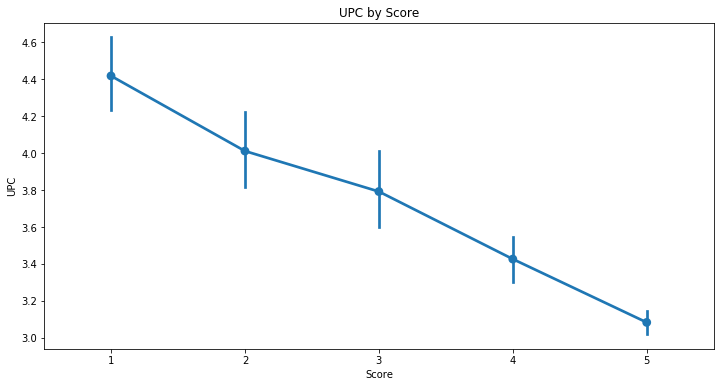

In [23]:
plt.subplots(figsize = (12, 6))
sns.pointplot(x="Score", y="UPC", data=df).set_title("UPC by Score")
plt.show()

### Mean Average Word Length by Score

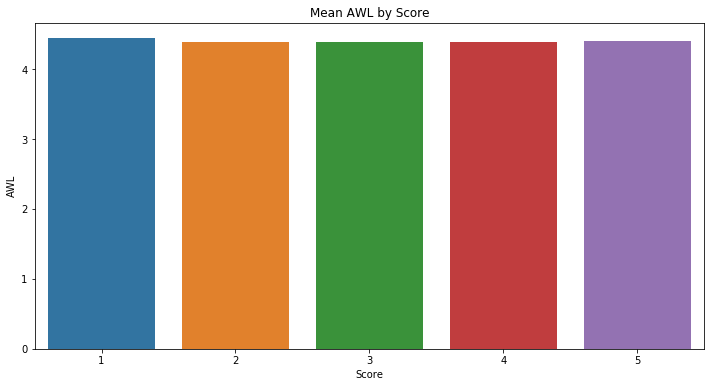

In [24]:
mean_wc_df = df.groupby('Score', as_index = False)['AWL'].mean()
plt.subplots(figsize = (12, 6))
sns.barplot(x = "Score", y = "AWL", data = mean_wc_df).set_title("Mean AWL by Score")
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


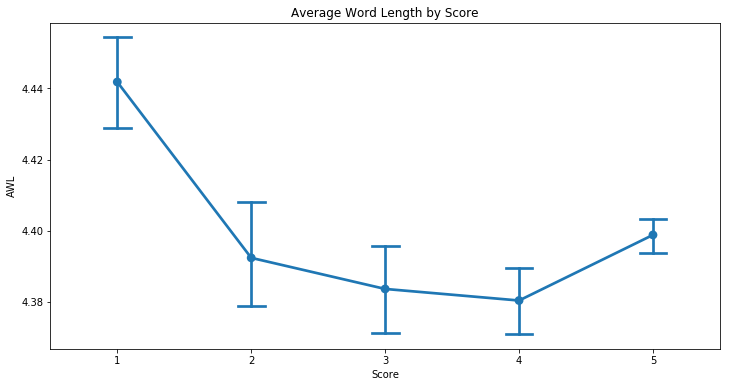

In [25]:
plt.subplots(figsize = (12, 6))
sns.pointplot(x="Score", y="AWL", data=df, capsize=.2).set_title("Average Word Length by Score")
plt.show()

### Mean Readability by Score

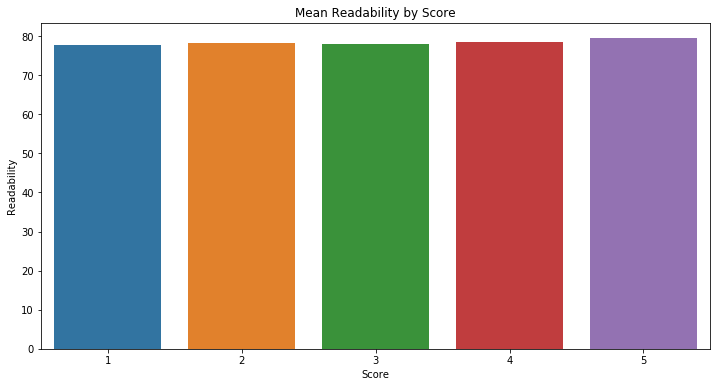

In [26]:
mean_wc_df = df.groupby('Score', as_index = False)['Readability'].mean()
plt.subplots(figsize = (12, 6))
sns.barplot(x = "Score", y = "Readability", data = mean_wc_df).set_title("Mean Readability by Score")
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


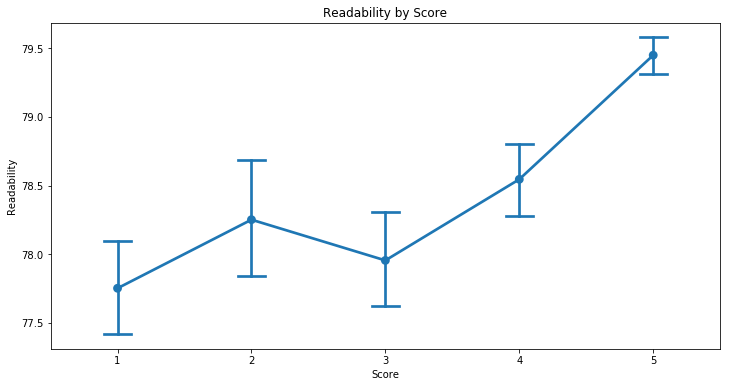

In [27]:
plt.subplots(figsize = (12, 6))
sns.pointplot(x="Score", y="Readability", data=df, capsize=.2).set_title("Readability by Score")
plt.show()

### Mean Flesch-Kincaid Grade by Score

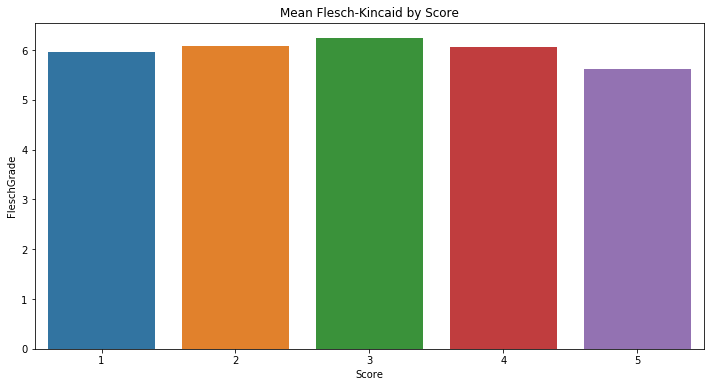

In [28]:
mean_wc_df = df.groupby('Score', as_index = False)['FleschGrade'].mean()
plt.subplots(figsize = (12, 6))
sns.barplot(x = "Score", y = "FleschGrade", data = mean_wc_df).set_title("Mean Flesch-Kincaid by Score")
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


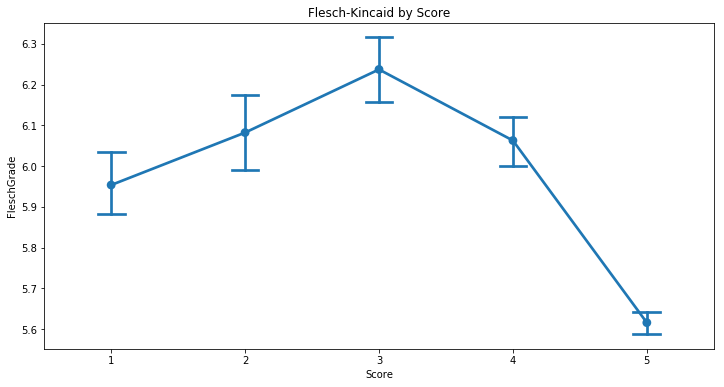

In [29]:
plt.subplots(figsize = (12, 6))
sns.pointplot(x="Score", y="FleschGrade", data=df, capsize=.2).set_title("Flesch-Kincaid by Score")
plt.show()

### Flesh-Kincaid vs. Word Count

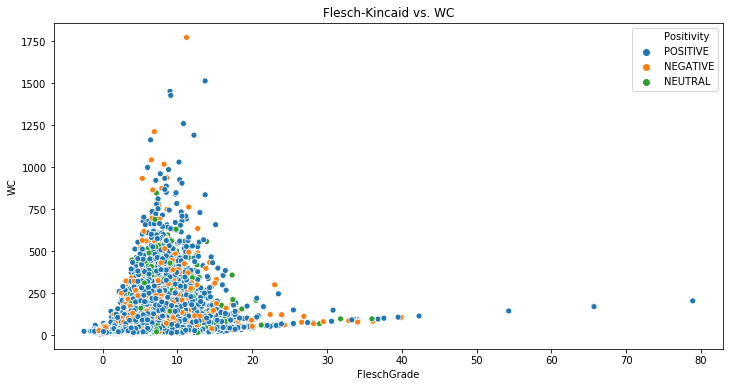

In [30]:
plt.subplots(figsize = (12, 6))
sns.scatterplot(x = "FleschGrade", y = "WC", data = df, hue="Positivity").set_title("Flesch-Kincaid vs. WC")
plt.show()

### Mean Readability by Helpfulness

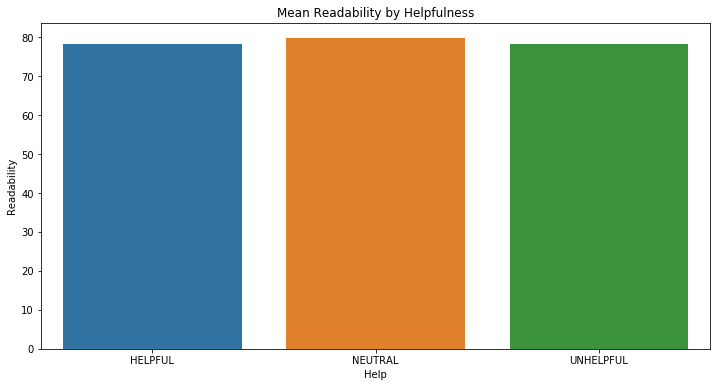

In [31]:
mean_wc_df = df.groupby('Help', as_index = False)['Readability'].mean()
plt.subplots(figsize = (12, 6))
sns.barplot(x = "Help", y = "Readability", data = mean_wc_df).set_title("Mean Readability by Helpfulness")
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


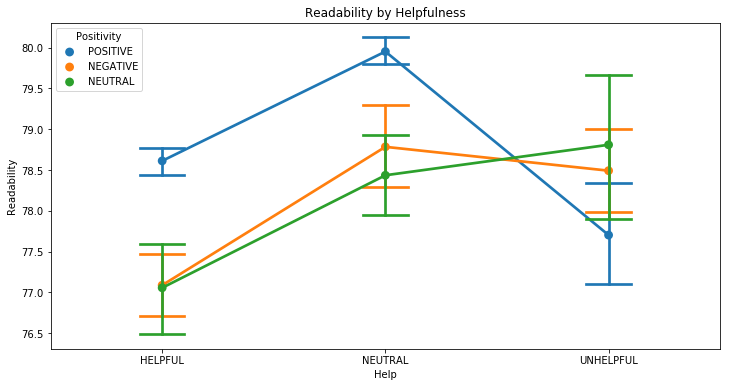

In [32]:
plt.subplots(figsize = (12, 6))
sns.pointplot(x="Help", y="Readability", data=df, capsize=.2, hue="Positivity").set_title("Readability by Helpfulness")
plt.show()

### Average Word Length vs. Readability

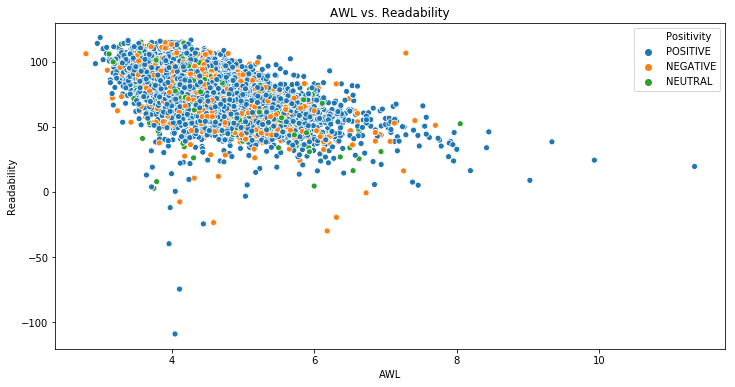

In [33]:
plt.subplots(figsize = (12, 6))
sns.scatterplot(x="AWL", y="Readability", data=df, hue="Positivity").set_title("AWL vs. Readability")
plt.show()

### Word Count vs. Readability

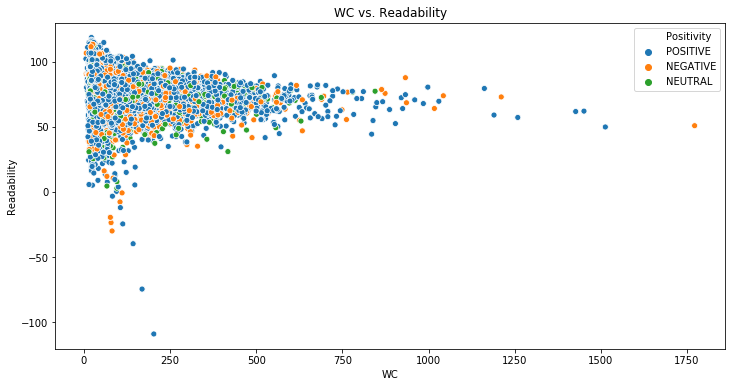

In [34]:
plt.subplots(figsize = (12, 6))
sns.scatterplot(x="WC", y="Readability", data=df, hue="Positivity").set_title("WC vs. Readability")
plt.show()

### Flesh-Kincaid Score vs. Readability

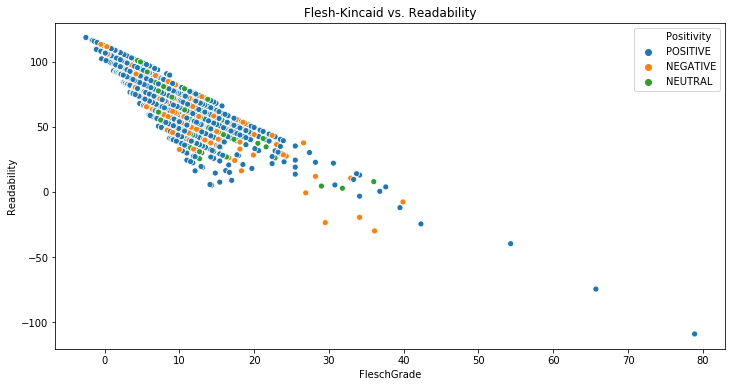

In [35]:
plt.subplots(figsize = (12, 6))
sns.scatterplot(x="FleschGrade", y="Readability", data=df, hue="Positivity").set_title("Flesh-Kincaid vs. Readability")
plt.show()

### Score vs. Uppercase Word Count

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


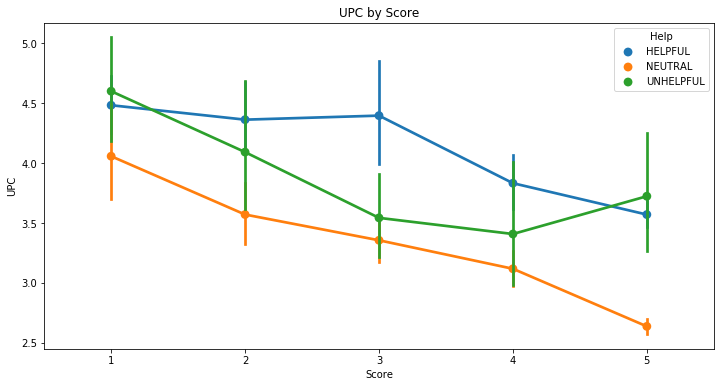

In [36]:
plt.subplots(figsize = (12, 6))
sns.pointplot(x="Score", y="UPC", data=df, hue="Help").set_title("UPC by Score")
plt.show()

### Mean Word Count by Score - Without Stopwords

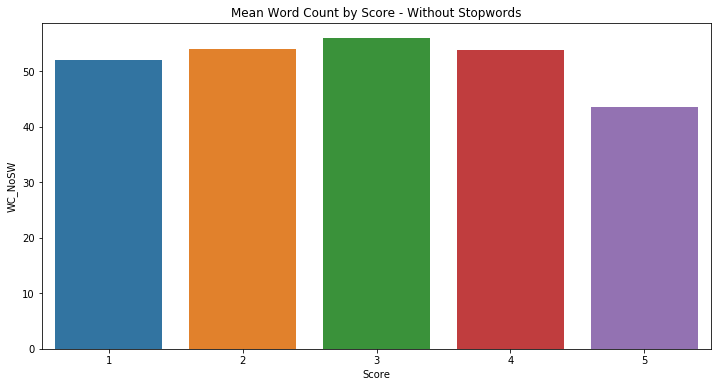

In [37]:
mean_wc_df = df.groupby('Score', as_index = False)['WC_NoSW'].mean()
plt.subplots(figsize = (12, 6))
sns.barplot(x = "Score", y = "WC_NoSW", data = mean_wc_df).set_title("Mean Word Count by Score - Without Stopwords")
plt.show()

### Mean Word Count by Positivity

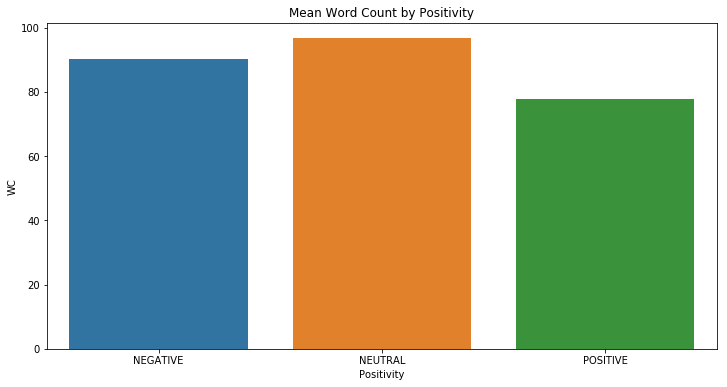

In [38]:
mean_wc_df = df.groupby('Positivity', as_index = False)['WC'].mean()
plt.subplots(figsize = (12, 6))
sns.barplot(x = "Positivity", y = "WC", data = mean_wc_df).set_title("Mean Word Count by Positivity")
plt.show()

### Mean Stopword Count by Score

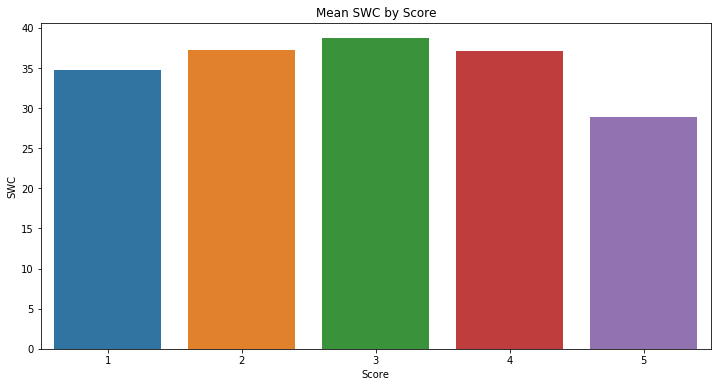

In [39]:
mean_wc_df = df.groupby('Score', as_index = False)['SWC'].mean()
plt.subplots(figsize = (12, 6))
sns.barplot(x = "Score", y = "SWC", data = mean_wc_df).set_title("Mean SWC by Score")
plt.show()

### Mean Word Count by Helpfulness

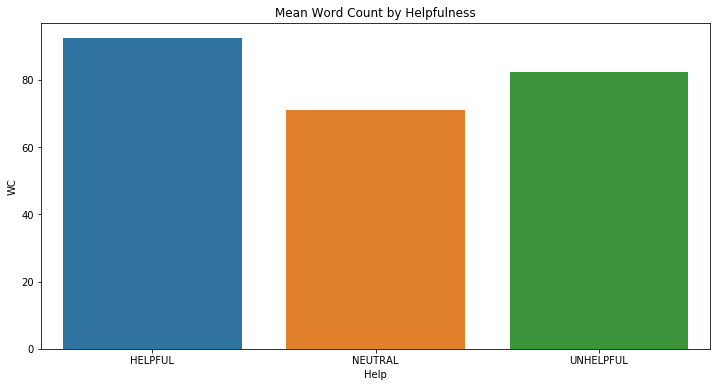

In [40]:
mean_wc_df = df.groupby('Help', as_index = False)['WC'].mean()
plt.subplots(figsize = (12, 6))
sns.barplot(x = "Help", y = "WC", data = mean_wc_df).set_title("Mean Word Count by Helpfulness")
plt.show()